In [4]:
# in case needed, sometimes the figures can be drawn with a seperate window
# the following two command enforces it to draw 'inline'
%matplotlib
%matplotlib inline
# ignore the warnings: can be useful for too many imag. part warnings 
import warnings
warnings.filterwarnings('ignore')
from numpy import *
from scipy import *
import numpy as np
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pylab import * # for plotting commands
import matplotlib.pyplot as plt
from numpy import (real,imag,matrix,linspace,array,complex)
from IPython.display import Image
from mpl_toolkits.mplot3d import axes3d

Using matplotlib backend: TkAgg


## DMRG method for Heisenberg model

Let us directly jump into the algorithm for the spin $1/2$ Heisenberg chain with nearest neighbor exchange couplings:

$$H = J \sum_{\langle ij \rangle} S_i \cdot S_j$$

#### 1. Consider a 4-site spin chain (J = 1):
$$H = \mathbf{S}_1 \cdot\mathbf{S}_2+ \mathbf{S}_2 \cdot\mathbf{S}_3 +\mathbf{S}_3 \cdot\mathbf{S}_4 $$        

Each operator are actually living in their subspace, e.g. $\mathbf{S}_1 = \mathbf{S}_1 \otimes \mathbf{I}\otimes \mathbf{I}\otimes \mathbf{I}$, $\mathbf{S}_2 = \mathbf{I} \otimes \mathbf{S}_2 \otimes \mathbf{I}\otimes \mathbf{I}$ and so on.

Define the operators:

In [14]:
Sigx = 0.5*np.array([[0.,1.],[1.,0.]])
Sigy = 0.5j*np.array([[0.,-1.],[1.,0.]])
Sigz = 0.5*np.array([[1.,0.],[0.,-1.]])
Sigp = Sigx+1j*Sigy
Sigm = Sigx-1j*Sigy

The system size and anisotropy term

In [21]:
L = 2
Jz = 1.

The elements of Heisenberg Hamiltonian are local operators, e.g. $I \otimes S_2^z \otimes S_3^z \otimes I$, we need these 2-body operators,

In [22]:
SigZZ = kron(Sigz,Sigz)
SigXX = kron(Sigx,Sigx)+ kron(Sigy,Sigy)

where $S^x S^x + S^y S^y$ are considered together. Or consider $\frac{1}{2}(S^+ S^- + S^- S^+)$ terms,

In [23]:
SigPMMP = 0.5*kron(Sigp,Sigm)+0.5*kron(Sigm,Sigp)

Let initialize the full Hamiltonian:

In [24]:
H_Heis = np.array(zeros((2**L,2**L),dtype='complex'))

We will define a for loop, take each $S^\alpha S^\alpha$ with bunch of identity operators to the right or left of it:

In [27]:
for i1 in arange(L-1):
    Hij = (SigPMMP+Jz*SigZZ)
    for i2 in arange(i1):
        Hij = kron(eye(2),Hij)
    for i2 in arange(i1+2,L):
        Hij = kron(Hij,eye(2))
    H_Heis = H_Heis + Hij
print(H_Heis)

[[ 0.5+0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j  1. +0.j  0. +0.j]
 [ 0. +0.j  1. +0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0.5+0.j]]


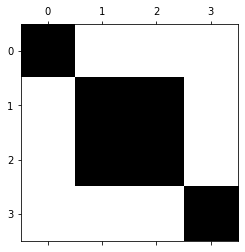

In [26]:
spy(H_Heis)

Let us define a function:

In [5]:
def XXZ_Ham(J,Jz,L):
    Sigx = 0.5*np.array([[0.,1.],[1.,0.]])
    Sigy = 0.5j*np.array([[0.,-1.],[1.,0.]])
    Sigz = 0.5*np.array([[1.,0.],[0.,-1.]])
    Sigp = Sigx+1j*Sigy
    Sigm = Sigx-1j*Sigy

    SigXX = kron(Sigx,Sigx)
    SigYY = kron(Sigy,Sigy)
    SigZZ = kron(Sigz,Sigz)
    SigPMMP = 0.5*kron(Sigp,Sigm)+0.5*kron(Sigm,Sigp)
    H_Heis = np.array(zeros((2**L,2**L),dtype='complex'))
    for i1 in arange(L-1):
        Hij = (SigPMMP+Jz*SigZZ)
        for i2 in arange(i1):
            Hij = kron(eye(2),Hij)
        for i2 in arange(i1+2,L):
            Hij = kron(Hij,eye(2))
        H_Heis = H_Heis + Hij
    return H_Heis

[[ 0.25+0.j  0.  +0.j  0.  +0.j  0.  +0.j]
 [ 0.  +0.j -0.25+0.j  0.5 +0.j  0.  +0.j]
 [ 0.  +0.j  0.5 +0.j -0.25+0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j  0.25+0.j]]


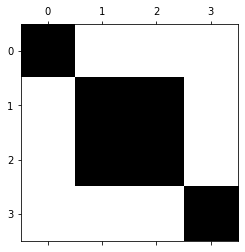

In [67]:
L = 2
J = 1.
Jz = 1.
H = XXZ_Ham(J,Jz,L)
spy(H)
print(H)

In [40]:
a,b = eig(H)

In [41]:
a[0]

(-0.9571067811865486+0j)

Yet, it is a good point to remind ourselves the basis. We used the representation along z-quantization axis. Just focus on $S^z$ operators. 
$$\begin{pmatrix} \uparrow \\ \downarrow \end{pmatrix}.$$

Yet, we have $L$ sites, we therefore need the kronecker product of this basis:
\begin{eqnarray}
&\to&\begin{pmatrix} \uparrow \\ \downarrow \end{pmatrix} \otimes \begin{pmatrix} \uparrow \\ \downarrow \end{pmatrix}\otimes \begin{pmatrix} \uparrow \\ \downarrow \end{pmatrix} ... \otimes \begin{pmatrix} \uparrow \\ \downarrow \end{pmatrix} \otimes \begin{pmatrix} \uparrow \\ \downarrow \end{pmatrix}\\
&=&\begin{pmatrix} \uparrow \uparrow \\  \uparrow \downarrow \\ \downarrow  \uparrow \\ \downarrow \downarrow \end{pmatrix}\otimes \begin{pmatrix} \uparrow \\ \downarrow \end{pmatrix} ... \otimes \begin{pmatrix} \uparrow \\ \downarrow \end{pmatrix} \otimes \begin{pmatrix} \uparrow \\ \downarrow \end{pmatrix}\\
&=&\begin{pmatrix} \uparrow \uparrow \uparrow \\ \uparrow \uparrow \downarrow \\  \uparrow \downarrow \uparrow \\ \uparrow \downarrow \downarrow \\ \downarrow  \uparrow \uparrow \\ \downarrow  \uparrow \downarrow \\ \downarrow \downarrow \uparrow \\ \downarrow \downarrow \downarrow \end{pmatrix} ... \otimes \begin{pmatrix} \uparrow \\ \downarrow \end{pmatrix} \otimes \begin{pmatrix} \uparrow \\ \downarrow \end{pmatrix} = \begin{pmatrix} \uparrow \uparrow \uparrow ... \uparrow \uparrow \\ \uparrow \uparrow \uparrow ... \uparrow \downarrow  \\  \uparrow \uparrow \uparrow ... \downarrow \uparrow  \\ . \\ . \\ .\\. \\. \\ . \\ \downarrow \downarrow \downarrow ... \downarrow \downarrow \end{pmatrix} \equiv \begin{pmatrix} 111 ... 11 \\ 111 ... 10 \\ 111 ... 01 \\ . \\ . \\ .\\. \\. \\ . \\ 000 ... 00\end{pmatrix}
\end{eqnarray}



#### 2. Diagonalize and obtain the density matrix

For now let us use built-in functions:

In [42]:
ei,vi =eig(H)
ndee1=argsort(ei)
ei = ei[ndee1]
vi = vi[:,ndee1]
ei[0:3]

array([-1.6160254 +0.j, -0.95710678+0.j, -0.95710678+0.j])

Ground state is NOT degenerate, therefore the density matrix for the groundstate $| \psi_0 \rangle$ is:
    $$\rho = \left| \psi_0 \rangle \langle \psi_0 \right|$$

<StemContainer object of 3 artists>

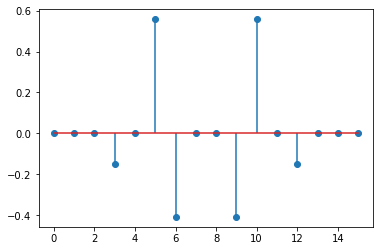

In [44]:
vi[:,0].shape
stem(vi[:,0])

In [52]:
v0 = reshape(vi[:,0],(16,1))
v1 = 0*reshape(vi[:,1],(16,1))

(16, 16)

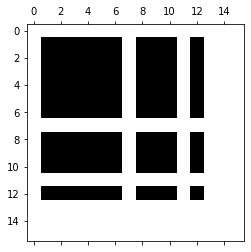

In [53]:
rho0 = dot(v0,conj(v0.T)) + dot(v1,conj(v1.T))
spy(rho0)
rho0.shape

Diagonalize and plot the eigenvalues:

<StemContainer object of 3 artists>

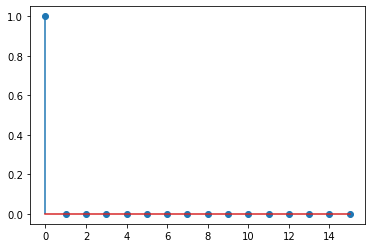

In [56]:
eRho,vRho =eig(rho0)
ndeeRho=argsort(-eRho)
eRho = eRho[ndeeRho]
vRho = vRho[:,ndeeRho]
stem(eRho)

Why? Clearly, it is a pure state and already diagonal!

<StemContainer object of 3 artists>

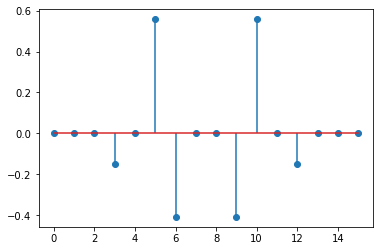

In [58]:
stem(vRho[:,0])

#### 3. Obtain the reduced density matrix and diagonalize it!

Dividing the system into two part $A$ and $B$, one can obtain the 'Schmidt' decomposition of the total wavefunction as
$$| \psi \rangle = \sum_{i \in A, j\in B}  \psi_{ij} |i \rangle |j \rangle.$$

Then, it is straightforward to obtain the reduced density matrix:
\begin{eqnarray}
\rho_A = Tr_B \left( \left| \psi_0 \rangle \langle \psi_0 \right|\right) &=& Tr_B \left(\sum_{i \in A, j\in B}\sum_{i' \in A, j'\in B} \psi_{i'j'}^* \psi_{ij} |i \rangle |j \rangle \langle i' | \langle j' |\right),\\
&=& \sum_{j_0\in B} \langle j_0 |\left(\sum_{i \in A, j\in B}\sum_{i' \in A, j'\in B} \psi_{i'j'}^* \psi_{ij} |i \rangle |j \rangle \langle i' | \langle j' |\right) | j_0 \rangle,\\
&=& \sum_{i,i' \in A} \left( \sum_{j\in B}  \psi_{i'j}^* \psi_{ij}\right) |i \rangle \langle i' | = \sum_{i,i' \in A} (\rho_A)_{ii'} |i \rangle \langle i' | 
\end{eqnarray}

Yet, how do we do this decomposition in the first place? 

Let us say, we would like to divide the system into two equal parts, the system and the environmenti respectively. Reshape function handles it automatically.

To summarize, we would like the keep the system in the following equivalent way:
$$\begin{pmatrix} \uparrow \uparrow \\ \uparrow \downarrow \\ \downarrow \uparrow \\ \downarrow \downarrow \end{pmatrix}\otimes \begin{pmatrix} \uparrow \uparrow \\ \uparrow \downarrow \\ \downarrow \uparrow \\ \downarrow \downarrow \end{pmatrix}$$

In [61]:
psi = reshape(v0,(2**int(L/2),2**int(L/2.)))
psi.shape

(4, 4)

$\psi_{ij}$ are the matrix elements of the representation, e.g. $\Psi$. The reduced density matrix $\rho_A$ are then nothing but a matrix multiplication, $\rho_A = \Psi \Psi^\dagger$. Then the matrix representation for $\rho_A$ becomes

In [62]:
rhoA = dot(psi,conj(psi.T))
print({"reduced density matrix is",rhoA.shape, "superblock matrix is",rho0.shape})


{(4, 4), 'reduced density matrix is', (16, 16), 'superblock matrix is'}


As seen clearly, the dimensionality is reduced to the size of the subsystem A. The next step is to diagonalize it!

$$\rho_A = U \sum_{p \in A} \lambda_p |p \rangle \langle p | U^\dagger$$

Text(0, 0.5, '$\\lambda_i$')

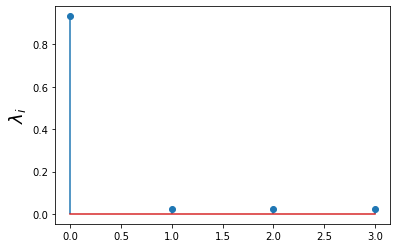

In [63]:
eA,vA =eig(rhoA)
ndeeA=argsort(-1.*eA)
eA = eA[ndeeA]
vA = vA[:,ndeeA]
stem(eA)
ylabel("$\lambda_i$",fontSize = 18)

The diagonalizing matrix is $vA$ in the code cell above. Yet, we would like to cut out the vectors having a contribution to the density matrix w.r.t. a pre-defined threshold, say $\epsilon = 1e-2$. These set of vectors diagonalizes the density matrix,
\begin{eqnarray}
\rho_A^{reduced} &=& (U)_{2^2 \times 2^2} \left( \sum_{p =1}^{2^2} \lambda_p  |p \rangle \langle p | \right)_{2^2 \times 2^2} (U^\dagger)_{2^2 \times 2^2}
\end{eqnarray}
Then, the 'truncated' density matrix can also be represented by the diagonal matrix that is sandwiched by a truncated approximate diagonalizing matrix $U_{trun.}$
\begin{eqnarray}
\rho_A \approx \rho_A^{trunc.} &=& (U_{trun.})_{2^2 \times m} \left( \sum_{p=1}^{m,\lambda_p > \epsilon}\lambda_p  |p \rangle \langle p | \right)_{m \times m} (U^\dagger_{trun.})_{m \times 2^2}
\end{eqnarray}

Let us obtain each element:

In [64]:
eps = 4e-3
indMax = sum(eA>eps)
vATr = vA[:,arange(indMax)]
eATr = eA[arange(indMax)]
print("total number of surviving vectors", indMax)
print("size of the truncated rotation matrix",vATr.shape)

total number of surviving vectors 4
size of the truncated rotation matrix (4, 4)


Therefore, we need all the vectors in this case!

In [65]:
Utr = vATr

#### 4. Enlarge the system and transform the operators!

Normally for a 4-site sytem devided into 2 equal parts, the Hamiltonian is:

$$H = H_A \otimes I_{2} + I_{2} \otimes H_B +\sum^\alpha S_L^\alpha \otimes S_R^\alpha , \quad \text{in this case, the sites are }L=2 \text{ and } R = 3$$

We now include an additional 2-sites within (site left and right denoted by $\mathbf{S}_{L,R}$, the 6-site Hamiltonian is:

- New $H_A$ is found as: $H_{A'} = H_A \otimes I_2 + \sum^\alpha S_2^\alpha \otimes S_L^\alpha$
- New $H_B$ is found as: $H_{B'} = I_2 \otimes H_B + \sum^\alpha S_R^\alpha \otimes S_3^\alpha$
- New $S_{L,R}$ is found as: $S_{L'} = I_2^2 \otimes S_L$ and $S_{R'} =  S_R \otimes  I_2^2$ 

Therefore, the total new Hamiltonian is:

$$H' = H_{A'} \otimes I_{2^3}+ I_{2^3}\otimes H_{B'} + \sum^\alpha S_{L'}^\alpha \otimes S_{R'}^\alpha $$

Yet, it seems like we have not considered the effect of the previous step step at all! Moreover, the size of the Hilbert space will increase exponentially since it is basically exact diagonalization, so far!

The effect of the previous iteration can be reflected at this step by transforming the operators of part-A of the whole system, $H_{A'}$ and $S_{L'}$ by the truncated matrix obtained from the reduced density matrix for part A, $U_{trun.}$ of size $2^2 \times m$. Then, these operators become:

\begin{eqnarray}
H_A &=& U_{trun.}^\dagger H_{A'} U_{trun.},\\
S_L &=& U_{trun.}^\dagger S_{L'} U_{trun.}
\end{eqnarray}

Therefore, the matrices of size $2^3 \times 2^3$ are truncated to $m \times m$ by this rotation. 

##### A quick dimensionality recap:

- We started with 4 site chain, $2^4 = 16$ of Hilbert space size, diagonalized it and obtained the density matrix, $\rho$ of size $16 \times 16$  for the ground state 
- Tracing out the section B (the environment), we ended up with $\rho_{A}$ of size $2^2 \times 2^2$. 
- Diagonalizing $\rho_{A}$ and keeping the first $m$ significant eigenvalues, we obtained a truncated matrix $U_{trun.}$ of size $2^2 \times m$
- We added one-more site to $H_A$ and created $H_{A'}$ of size $2^3 \times 2^3$.

Wait a sec! There is something wrong! 

#### 5. Repeat the procedure for 4 initial sites where 2-sites are added:
The dimensional error is due neglecting the existence of the initially added 2-sites! It means what we thought as $H_A$ is actually $H_A'$! 

- How to remedy this? A: start adding the 2-sites at the first iteration!

Generally we have the following Hamiltonian for the system: $(Block-A) - (site-L) - (site-R) - (Block-B)$ denoted by $H = H_{AA} + H_{AL}+H_{LR}+H_{RB} + H_{BB}$

where, in the next iteration, we will have

\begin{eqnarray}
H_{A'A'} &=& H_{AA} + H_{AL}\\
H_{B'B'} &=& H_{RB} + H_{BB}.
\end{eqnarray}

At each iteration, we add 2-sites to the system. Calculate the truncation matrices to project the Block-A and Block-B into smaller matrices. Project all operators into this basis! 

The function defined below is divided into steps $(1)-(2)-..$ to explain each step in detail:

- (1): Generate the local operators for the couplings between (system-A)-(left-spin) and (right-spin)-(system-B) : $\quad \quad H_{AL}$ and $H_{RB} $

- (2): Generate the operator $H_{LR}$ out of the local $H_{LR}^{local} = \vec{S}_L \cdot \vec{S}_R$ Hamiltonian, $I_A \otimes H_{LR}^{local} \otimes I_B$. 

- (3): Generate the new Hamiltonians for block A and B: $\quad H_{A'A'}$ and $H_{B'B'}$. The trick: Size of $I$ matrix for the second terms in each sum $I \otimes H_{AL}$ must be selected properly because $H_{AL}$ already contains the last "spin" of old block-A. the variable $dimSxL$ takes care of dimensional reduction.

- (4): The enlarged spin matrices, which are going to be the last "spins" of block A and B IN THE NEXT  ITERATION, are nothing but spin-$1/2$ matrices kronecker product of Block-A or B.

- (5): Create the full Hamiltonian as the sum of all components and diagonalize it. Calculate the reduced density matrix $\rho_A = Tr_B(\rho)$ where $\rho = |\psi_0\rangle \langle \psi_0|$, directly by the matrix multiplication of the "reshaped" wavefunctions, $ |\psi_0\rangle  = \sum_{i j} \psi_0^{ij} |i\rangle_A \otimes |j\rangle_B $. IF one denotes the matrix elements $ \psi_0^{ij} $ as the matrix $\Psi_0$, then the trace operation is basically a matrix multiplication: $\rho_A = \Psi_0 \Psi_0^\dagger$. For the details, see part 3 above.

- (6): Diagonalize $\rho_A$ and calculate the diagonalizing unitary matrix, which is noting but the eigenvectors. Truncate it with respect to a treshhold by picking first $m$ elements. $ U^{trunc.} = U(:,1:m) $ is an $Size_{Block-A} \times m$ matrix.

- (7): Sandwich all the enlarged operators as $U^\dagger (..) U$ and the resulting rotated (or projected) operators are $m \times m$.

- Repeat the procedures with the relevant outputs as inputs.

In [19]:
def Enlarge2Site(HA,HB,SxL,SyL,SzL,SxR,SyR,SzR,Jz,eps,i0):
    Sigx = 0.5*np.array([[0.,1.],[1.,0.]])
    Sigy = 0.5j*np.array([[0.,-1.],[1.,0.]])
    Sigz = 0.5*np.array([[1.,0.],[0.,-1.]])

    ## (1)
    HAL = kron(SxL,Sigx)+kron(SyL,Sigy)+Jz*kron(SzL,Sigz) 
    HRB = kron(Sigx,SxL)+kron(Sigy,SyL)+Jz*kron(Sigz,SzL)
    
    ## (2)
    HLR_local = kron(Sigx,Sigx)+kron(Sigy,Sigy)+Jz*kron(Sigz,Sigz)     
    HLR = kron(kron(eye(int(HA.shape[0])),HLR_local),eye(int(HB.shape[0])))
    
    ## (3)
    dimSxL = prod(SxL.shape[0])
    HApAp = kron(HA,eye(2)) + kron(eye(int(HA.shape[0]/dimSxL)),HAL) 
    HBpBp = kron(eye(2),HA) + kron(HRB,eye(int(HB.shape[0]/dimSxL))) 

    ## (4)
    SxL = kron(eye(int(HA.shape[0])),Sigx)
    SyL = kron(eye(int(HA.shape[0])),Sigy)
    SzL = kron(eye(int(HA.shape[0])),Sigz)
    SxR = kron(Sigx,eye(int(HB.shape[0])))
    SyR = kron(Sigy,eye(int(HB.shape[0])))
    SzR = kron(Sigz,eye(int(HB.shape[0])))
    
    ## (5)
    H = kron(HApAp,eye(int(HBpBp.shape[0])))  +  kron(eye(int(HApAp.shape[0])),HBpBp) +  HLR
    
    ei,vi =eigh(H)
    ndee1=argsort(ei)
    ei = ei[ndee1]
    vi = vi[:,ndee1]
    
    v0 = reshape(vi[:,0],(prod(vi[:,0].shape),1))    
    psi0 = reshape(v0,(int(sqrt(H.shape[0])),int(sqrt(H.shape[0]))))

    rhoA = dot(psi0,conj(psi0.T))
 
    ## (6)
    eA,vA =eigh(rhoA)
    ndeeA=argsort(-eA)
    eA = eA[ndeeA]
    vA = vA[:,ndeeA]
    
    indMax = sum(eA>eps)
    UTr = vA[:,arange(indMax)]
    eATr = eA[arange(indMax)]
    
    ## (7)
    HA = dot(conj(UTr.T),dot(HApAp,UTr))
    HB = dot(conj(UTr.T),dot(HBpBp,UTr))

    SxL = dot(conj(UTr.T),dot(SxL,UTr))
    SyL = dot(conj(UTr.T),dot(SyL,UTr))
    SzL = dot(conj(UTr.T),dot(SzL,UTr))
    
    SxR = dot(conj(UTr.T),dot(SxR,UTr))
    SyR = dot(conj(UTr.T),dot(SyR,UTr))
    SzR = dot(conj(UTr.T),dot(SzR,UTr))
    
    return HA,HB,SxL,SyL,SzL,SxR,SyR,SzR,ei[0]/(2*i0+6.),eA[0]

In [20]:
J = 1.
Jz = 1.
L = 2
HA = XXZ_Ham(J,Jz,L)
HB = HA

Sigx = 0.5*np.array([[0.,1.],[1.,0.]])
Sigy = 0.5j*np.array([[0.,-1.],[1.,0.]])
Sigz = 0.5*np.array([[1.,0.],[0.,-1.]])

eps = 3e-5
SxL,SyL,SzL,SxR,SyR,SzR = Sigx,Sigy,Sigz,Sigx,Sigy,Sigz
error = 100.
threshold = 1e-5
MaxIteration =1000
eint = 100
eA = 100
energies = zeros((MaxIteration-L,),dtype = 'double')
i0 = 0

while (error>threshold) and (i0<MaxIteration-L):
    HA,HB,SxL,SyL,SzL,SxR,SyR,SzR,energies[i0],eA = Enlarge2Site(HA,HB,SxL,SyL,SzL,SxR,SyR,SzR,Jz,eps,i0)
    error = abs((eint-energies[i0]))
    eint = energies[i0]
    i0 = i0 + 1
#(H.shape, HAL.shape,HBR.shape,SxR.shape,SxL.shape,vATr.shape,indMax)

In [21]:
eA

0.4850607766776133

-0.44188993791666265

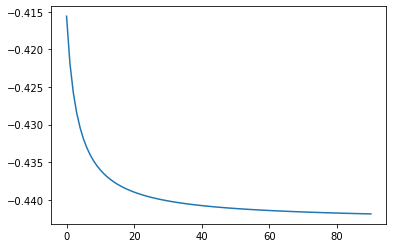

In [22]:
plot(energies[arange(i0)])
energies[i0-1]

Well, it looks like we are getting somewhere, just check Bethe's XXX-model $S=1/2$ energy solution per site: $E_0 = 1/4- ln(2)$

In [131]:
print("Exact GS energy is ",0.25-log(2))

Exact GS energy is  -0.4431471805599453


We indeed already introduced an max chain length by a while loop. This will be useful in the next section when we do sweeping. The only thing that might be of a worry is that DMRG is a variational method, i.e. an estimate of the energy from above, NOT below. 

#### 5. Do sweeping several times until exact-like convergence